# BPM 2 Propagazione anisotropa
## Creazione Mach-Zehnder


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from matplotlib import cm
import time

from cupyx.scipy.special import erf
fft,ifft=cp.fft.fft,cp.fft.ifft

In [0]:
#Parametri fisici onda

Ip=(1)^2; 							
l=0.5*10**(-6);			
k=2*np.pi/l;  				
n0=1.5; 
 						
Dn=8e-4         
w0=15e-6  
Guide_width=30e-6
MaxD=3e-5;                
StepLength=0.012  
LengthSeparation=0.015  

dn_michelson=2*np.sqrt(2)*0.0000166667
Dz_michelson=15e-3
pos=0.

In [0]:
#Parametri domini spaziali

Lz=0.12					
Lx=400e-6 	

nx=1024*2   
nz=800*2

In [0]:
#Reticolo spaziale
z=cp.linspace(0,Lz+Lz/nz,nz)
x=-Lx/2+cp.arange(0,nx)*Lx/nx

#Utili per i plot
xp=cp.asnumpy(x)
zp=cp.asnumpy(z)

X,Z=cp.meshgrid(x,z)

Xp,Zp=np.meshgrid(xp,zp)
print(X.shape,Z.shape)

(1600, 2048) (1600, 2048)


In [0]:
#Dominio trasformata
ntx=0
kx = cp.zeros(nx)                                          
for nn in range(nx):
    ikx = nn - ntx
    kx[nn] = 2*np.pi/Lx*ikx
    if nn + 1 - nx/2 == 0 :
      ntx = nx
print(kx.shape)

(2048,)


In [0]:
#Variazioni degli spostamenti lungo z

dx1=MaxD*(0.5+0.5*erf((z-StepLength*2)/(StepLength)))*(
    0.5-0.5*erf((z-LengthSeparation-StepLength*5)/StepLength))

#dx2=-MaxD*(0.5+0.5*erf((z-StepLength*2)/(StepLength)))*(
#    0.5-0.5*erf((z-LengthSeparation-StepLength*5)/StepLength))
dx2=-dx1.copy()
print(dx2.shape,dx1.shape)

(1600,) (1600,)


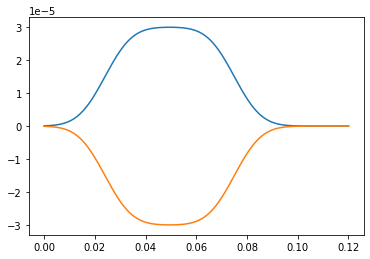

In [0]:
plt.plot(zp,cp.asnumpy(dx1))
plt.plot(zp,cp.asnumpy(dx2))

In [0]:
# Variazioni delle riflessioni
R=w0/np.sqrt(2)

In [0]:
#Individua una particolare fibra di mach zender
def fiber(dx,dn):
  dna=cp.asnumpy(dn)
  dxa=cp.asnumpy(dx)
  dk=np.tile(dxa,(nx,1)).T
  dna=dna*np.heaviside(Xp+dk+Guide_width/2,0)*np.heaviside(
      -Xp-dk+Guide_width/2,0)
  return(cp.asarray(dna))

def fiber_g(dx,dn):
  dk=cp.tile(dx,(nx,1)).T
  dn=dn*cp.exp(-((X+dk)/(Guide_width/2))**12) #gaussiano spinto
  return(dn)

def fiber_p(dx,dn):
  dna=cp.asnumpy(dn)
  dxa=cp.asnumpy(dx)
  dk=np.tile(dxa,(nx,1)).T
  dna=dna*(1-((Xp+dk)/R)**2)*np.heaviside(1-((Xp+dk)/R)**2,0)
  return(cp.asarray(dna))


# definizione della fibra in base alla funzione

def shape(name,amp=Dn):

  dn1=amp*cp.ones((nz,nx))
  dnp=(1+dn_michelson*cp.exp(-(
      Z-z[np.argmax(dx1)])**82/((Dz_michelson/2)**82)))
  dn2=dn1.copy()

  if name=='heav':
    dn1=fiber(dx1,dn1)
    dn2=fiber(dx2,dn2)

  if name=='gaus':
    dn1=fiber_g(dx1,dn1)
    dn2=fiber_g(dx2,dn2)

  if name=='para':
    dn1=fiber_p(dx1,dn1)
    dn2=fiber_p(dx2,dn2)

  dn2=dn2*dnp
  dn=np.maximum(dn1,dn2)
  return(cp.asarray(dn))

(1600, 2048)


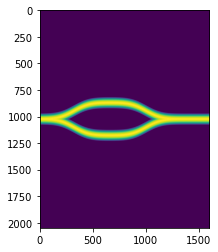

In [0]:
dnp=cp.asnumpy(shape('para'))
plt.imshow(dnp.T)
print(dnp.shape)

In [0]:
#Propagazione del campo
def propa(Ip,dn,i,prop,kp=k):
    Ipf=cp.zeros(Ip.shape[0],dtype=complex)
    Ipf=fft(Ip,n=nx)*prop
    Ip=ifft(Ipf,n=nx)
    Ip=Ip*cp.exp(-1j*(k*Lz/nz*dn[i,:]))
    Ipf=fft(Ip,n=nx)*prop
    Ip=ifft(Ipf,n=nx)
    return(Ip)

In [0]:
## Funzione che raccoglie tutte le variabili 
# Integrazione immediata
# Restituisce come array numpy perché è più facile da plottare

def mach_zender(Ip=1,l=0.5e-6,n0=1.5,w0=15e-6,name='heav',it=True):
  tstart=time.time()
  k=2*np.pi/l;  
  prop=cp.exp(1j*(kx*kx*Lz/4/nz/k/n0))
  I=Ip**0.5*cp.exp(-((x-pos)/(w0))**2)
  R=w0/np.sqrt(2)
  dn=shape(name)
  IC=cp.zeros((nx,nz),dtype=complex)
  IC[:,0]=I
  IP=cp.zeros((nx,nz))
  IP[:,0]=cp.abs(I)**2
  for i in range(1,nz):
    I=propa(I,dn=dn,i=i,prop=prop,kp=k)
    IC[:,i]=I
    IP[:,i]=cp.abs(I)**2
  
  print('Differenze energie',sum(IP[:,0])-sum(IP[:,-1]))
  print("Integrazione completata!\nDurata:",time.time()-tstart)

  if it:
    return(cp.asnumpy(IP),cp.asnumpy(IC))
  else:
    return(cp.asnumpy(IC))

IP,IC=mach_zender(name='heav')


Differenze energie -1.0315659437765134e-10
Integrazione completata!
Durata: 1.9198827743530273


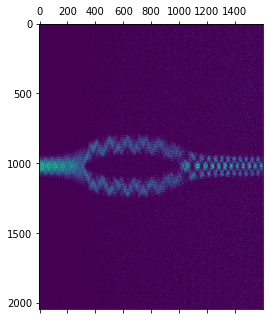

In [0]:
plt.matshow(IP)

In [0]:
#plotta le immagini, ci sono problemi con gli array cp
def plot(Power, figsize=(4, 4), width=15, unit="mm"):
  if type(Power)==cp.core.core.ndarray:
    Power = cp.asnumpy(Power)
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, cmap=cm.RdBu_r, extent=[-width,width,-width,width], vmin=0)
  return fig, ax


(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0f4259d518>)

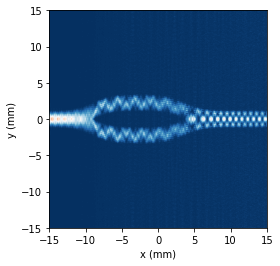

In [0]:
plot(IP)

## Mach-Zender con doppia onda
Inseriemo due onde di diversa lunghezza onda e osserviamo che cosa succede al campo. le onde incontreranno un indice di rifrazione diverso in base al colore. La propagazione avverrà in maniera separata ma in seguito si sommeranno le intensità dei campi.<br>
I dati relativi la variazione dell'indice di rifrazione sono reperibili in https://refractiveindex.info/?shelf=glass&book=fused_silica&page=Malitson 

In [0]:
!wget https://refractiveindex.info/tmp/data/main/SiO2/Malitson.csv

--2020-05-27 13:19:18--  https://refractiveindex.info/tmp/data/main/SiO2/Malitson.csv
Resolving refractiveindex.info (refractiveindex.info)... 50.62.230.242
Connecting to refractiveindex.info (refractiveindex.info)|50.62.230.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2360 (2.3K) [text/csv]
Saving to: ‘Malitson.csv’

Malitson.csv        100%[===================>]   2.30K  --.-KB/s    in 0s      

2020-05-27 13:19:19 (64.8 MB/s) - ‘Malitson.csv’ saved [2360/2360]



In [0]:
## Caricamento dei dati 
# Colonna 1: lunghezza d'onda
# Colonna 2 indice di rifrazione
wl,n=np.loadtxt('Malitson.csv',delimiter=',',skiprows=1,unpack=True)
wl=wl*1e-6
print(wl.shape,n.shape)
print(wl)
print(n)

(101,) (101,)
[2.100e-07 2.174e-07 2.251e-07 2.330e-07 2.412e-07 2.497e-07 2.585e-07
 2.676e-07 2.770e-07 2.868e-07 2.969e-07 3.074e-07 3.182e-07 3.294e-07
 3.410e-07 3.530e-07 3.655e-07 3.783e-07 3.917e-07 4.055e-07 4.197e-07
 4.345e-07 4.498e-07 4.657e-07 4.821e-07 4.991e-07 5.167e-07 5.349e-07
 5.537e-07 5.732e-07 5.934e-07 6.143e-07 6.360e-07 6.584e-07 6.816e-07
 7.056e-07 7.305e-07 7.562e-07 7.829e-07 8.104e-07 8.390e-07 8.686e-07
 8.992e-07 9.308e-07 9.636e-07 9.976e-07 1.033e-06 1.069e-06 1.107e-06
 1.146e-06 1.186e-06 1.228e-06 1.271e-06 1.316e-06 1.362e-06 1.410e-06
 1.460e-06 1.512e-06 1.565e-06 1.620e-06 1.677e-06 1.736e-06 1.797e-06
 1.861e-06 1.926e-06 1.994e-06 2.064e-06 2.137e-06 2.212e-06 2.290e-06
 2.371e-06 2.454e-06 2.541e-06 2.630e-06 2.723e-06 2.819e-06 2.918e-06
 3.021e-06 3.128e-06 3.238e-06 3.352e-06 3.470e-06 3.592e-06 3.719e-06
 3.850e-06 3.986e-06 4.126e-06 4.271e-06 4.422e-06 4.578e-06 4.739e-06
 4.906e-06 5.079e-06 5.258e-06 5.443e-06 5.635e-06 5.833e-06 6.

In [0]:
def mach_zender_poli(Ip=1,l=cp.asarray([0.6e-6,4.27e-6]),
                     n0=cp.asarray([1.5,1.6]),w0=15e-6,name='heav'):
  tstart=time.time()
  l_i=len(l)
  IC=np.zeros((l_i,nx,nz),dtype=complex)
  IP=np.zeros((nx,nz))
  for i in range(len(l)):
    print(f"Lunghezza d'onda={wl[i]}")
    IC[i,:,:]=mach_zender(Ip,l[i],n0[i],w0,name=name,it=False)
  IP=abs(np.sum(IC,axis=0))**2
  print('\n'+'Durata integrazione '+f'{time.time()-tstart}\n')
  return(IP,IC)

In [0]:
IPp,ICp=mach_zender_poli(l=cp.asarray(wl),n0=cp.asarray(n),name='para')
dnpo=cp.asnumpy(shape('para',1))
IPp.shape

Differenze energie -1.0292922070220811e-10
Integrazione completata!
Durata: 1.9191515445709229
Differenze energie -9.738698736327933e-11
Integrazione completata!
Durata: 1.9361310005187988
Differenze energie -9.677592061052565e-11
Integrazione completata!
Durata: 1.9001471996307373
Differenze energie -9.916334420267958e-11
Integrazione completata!
Durata: 1.8916990756988525
Differenze energie -9.950440471584443e-11
Integrazione completata!
Durata: 1.90256929397583
Differenze energie -9.480061180511257e-11
Integrazione completata!
Durata: 1.9180243015289307
Differenze energie -1.0173550890613114e-10
Integrazione completata!
Durata: 1.923506498336792
Differenze energie -1.0047074283647817e-10
Integrazione completata!
Durata: 1.8928775787353516
Differenze energie -9.7855945568881e-11
Integrazione completata!
Durata: 1.914438247680664
Differenze energie -1.000017846308765e-10
Integrazione completata!
Durata: 1.9055554866790771
Differenze energie -9.92486093309708e-11
Integrazione completat

(2048, 1600)

In [0]:
fig=plt.figure(figsize=(50,50))
for i in range(100):
  ax=fig.add_subplot(10,10,i+1)
  ax.axis('off')
  ax.imshow(abs(ICp[i,...])**2)
  ax.set_title(f'{i}')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
fig.savefig('all_lamb.png')
fig.clear()

In [0]:
#Estrazione colore rosso e blu
print(wl[22],wl[33])

4.4979999999999996e-07 6.583999999999999e-07


In [0]:
#Estrazione campo e successiva analisi
ICr=ICp[33,...]
ICb=ICp[22,...]
IPrb=abs(ICr+ICb)**2

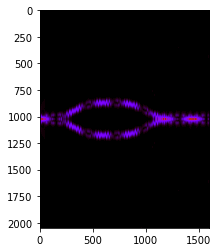

In [0]:
plt.imshow(IPrb,cm.gnuplot)

In [0]:
def plot_subse(z_p,ax):
  if ax==None:
    fig,ax=plt.subplots(figsize=(4,3))
  ax.plot(xp,IPrb[:,z_p])
  ax.plot(xp,abs(ICr[:,z_p])**2,'r')
  ax.plot(xp,abs(ICb[:,z_p])**2,'b')

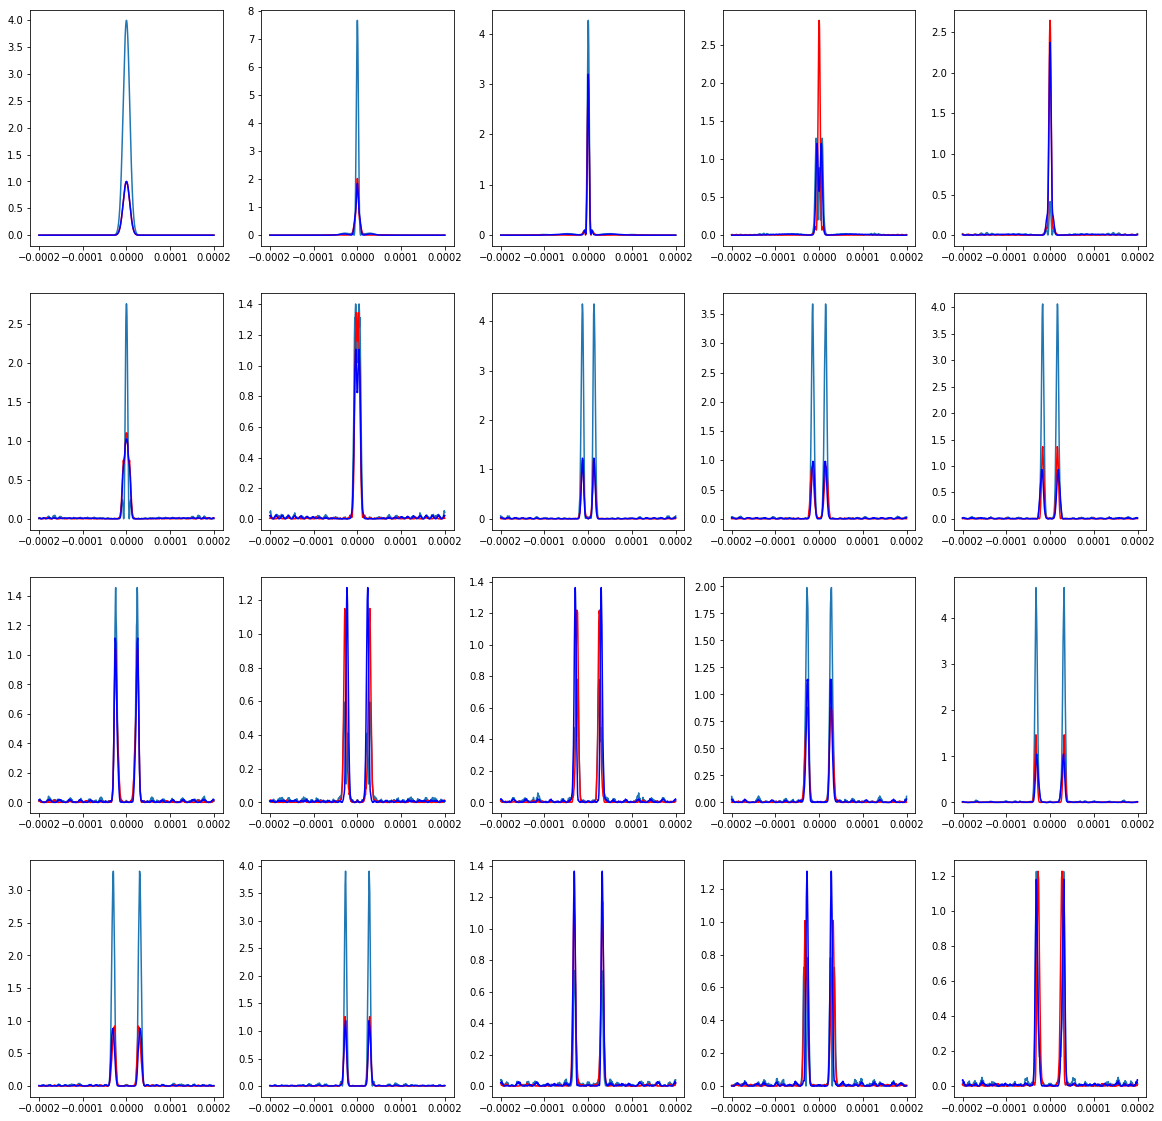

In [0]:
fig=plt.figure(figsize=(20,20))
for i in range(20):
  ax=fig.add_subplot(4,5,i+1)
  plot_subse(i*40,ax)

In [0]:
#Funzione di plot sfasamenti

def plot_sfa(IPp,ICp,dn,z_p):
  plt.plot(xp,dn[z_p,:],'black')
  plt.plot(xp,IPp[:,z_p])
  for i in range(ICp.shape[0]):
    plt.plot(xp,ICp[i,:,z_p].real)